<a href="https://colab.research.google.com/github/Danielrcnn/Redes-Neurais/blob/master/Trabalho_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Para executar: ## 
  # Primeramente, deve-se pegar o seu Token (kaggle.json):
    # Logado em seu perfil do Kaggle, vá em "Account" e procure por API, após achar, clique em "Create Nem API Token";
    # Após baixar seu Token, upe ele aqui.
  # Pronto, só executar a rede.

In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d felsal/ibovespa-stocks

100% 24.6M/24.6M [00:00<00:00, 20.0MB/s]



In [3]:
!unzip \*.zip && rm *.zip

Archive:  ibovespa-stocks.zip
  inflating: b3_stocks_1994_2020.csv  
  inflating: selic.csv               
  inflating: usd2brl.csv             


In [4]:
Path = "/content/"
ticker = 'BBAS3'

In [5]:
Teste = pd.read_csv('b3_stocks_1994_2020.csv') #,header=None, skiprows=1
Teste.head()

,datetime,ticker,open,close,high,low,volume
0,1994-07-04,ACE 3,48.00,48.00,48.00,47.00,46550.0
1,1994-07-04,ALP 3,155.27,156.00,156.00,155.27,163405.8
2,1994-07-04,ALP 4,131.00,131.00,131.00,131.00,6550.0
3,1994-07-04,IBP 6,600.00,600.00,600.00,600.00,7800.0
4,1994-07-04,AQT 4,0.89,0.99,0.99,0.85,13137.0


In [19]:
df_ticker = Teste[Teste['ticker'] == ticker]
len(df_ticker)

5635

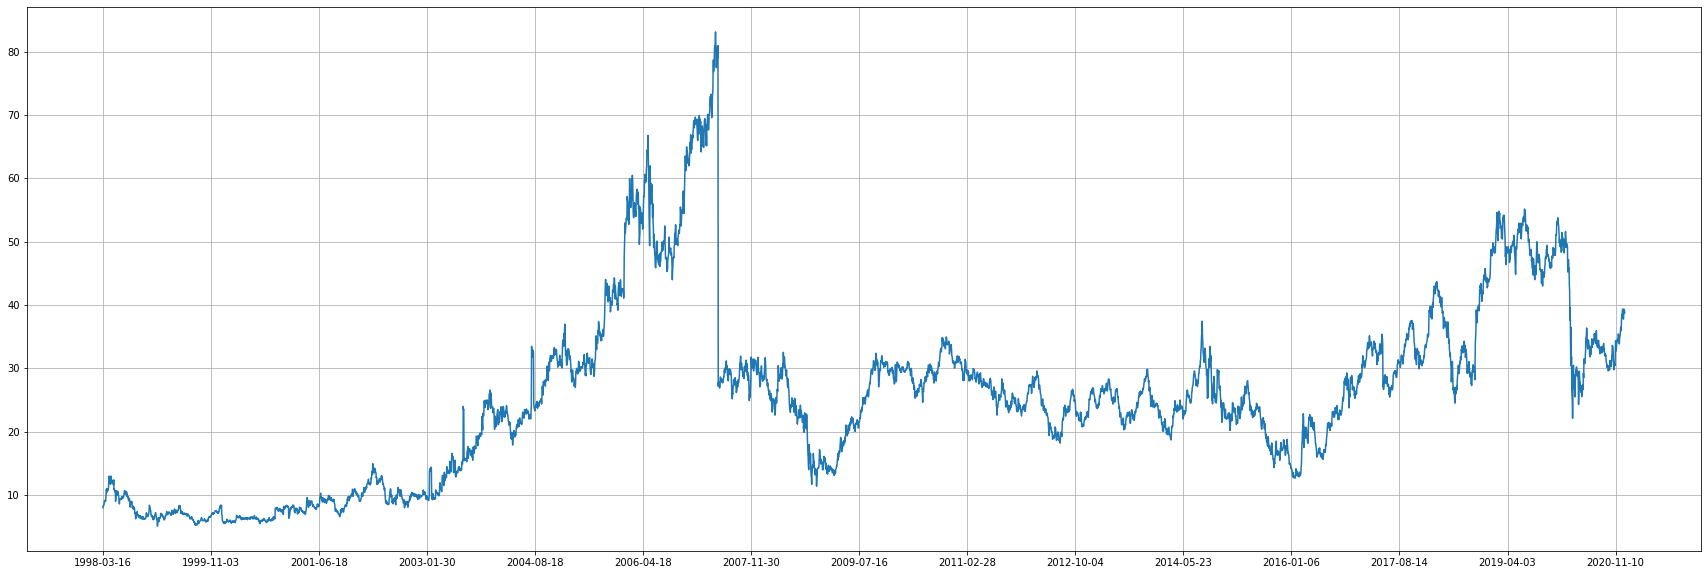

In [61]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(df_ticker['datetime'], df_ticker['close'])
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.grid()

In [45]:
def create_df_windows(df, window_size, predict_ahead):
    x, y = [], []

    for i in range(len(df)-window_size-predict_ahead):
        x.append(df.iloc[i:i+window_size])
        y.append(df.iloc[i+window_size+predict_ahead-1])
    
    return x, y


def normalize_columns(df_x, df_y, cols):
    norm_x = df_x[cols] / df_x[cols].iloc[0] - 1
    norm_y = df_y.to_frame().T[cols] / df_x[cols].iloc[0] - 1

    return norm_x, norm_y

def denorm_columns(df_x, df_norm_x, df_norm_y, cols):
    df_denorm_x = df_x[cols].iloc[0] * (df_norm_x[cols] + 1)
    df_denorm_y = df_x[cols].iloc[0] * (df_norm_y[cols] + 1)

    return df_denorm_x, df_denorm_y

def create_dataset(df, window_size, predict_ahead, x_cols, y_col):
    x_windows, y_windows = create_df_windows(df, window_size, predict_ahead)

    # x_cols must be in list format
    x_cols = x_cols if isinstance(x_cols, list) else [x_cols]
    x_lst, y_lst = [], []

    for x_window, y_window in zip(x_windows, y_windows):

        x_norm, y_norm = normalize_columns(x_window, y_window, x_cols)

        x_lst.append(x_norm.to_numpy())
        y_lst.append(y_norm[y_col].to_numpy().astype('float').squeeze())

    return x_windows, y_windows, np.stack(x_lst), np.stack(y_lst)

def split_train_test(items, train_pct=0.8):
    results = []
    for item in items:
        split_i = int(len(item)*train_pct)
        results.append(item[:split_i])
        results.append(item[split_i:])
    
    return tuple(results)

In [116]:
features = ['close', 'open']
target = ['close']
window_size = 20
predict_ahead = 1

x_windows, y_windows, x_norm, y_norm = create_dataset(df_ticker, window_size, predict_ahead, features, target)
x_norm.shape, y_norm.shape

((5614, 20, 2), (5614,))

In [136]:
x_train, x_test, y_train, y_test = split_train_test([x_windows, y_windows], train_pct=0.70)
x_norm_train, x_norm_test, y_norm_train, y_norm_test = split_train_test([x_norm, y_norm], train_pct=0.70)

In [137]:
model = Sequential()
model.add(GRU(50, activation= 'tanh', return_sequences=True, input_shape= (x_norm_train.shape[1], len(features))))
model.add(GRU(50, activation= 'tanh', return_sequences= True))
model.add(GRU(1, activation= 'tanh', return_sequences= False))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [138]:
Treinamento_da_Rede = model.fit(x_norm_train, y_norm_train, validation_data=(x_norm_test, y_norm_test), batch_size=64, epochs=15, verbose=1)

Epoch 1/15
62/62 [==============================] - 8s 53ms/step - loss: 0.0056 - accuracy: 0.0042 - val_loss: 0.0025 - val_accuracy: 0.0018
Epoch 2/15
62/62 [==============================] - 2s 38ms/step - loss: 0.0028 - accuracy: 0.0060 - val_loss: 0.0017 - val_accuracy: 0.0018
Epoch 3/15
62/62 [==============================] - 2s 37ms/step - loss: 0.0022 - accuracy: 0.0034 - val_loss: 0.0015 - val_accuracy: 0.0018
Epoch 4/15
62/62 [==============================] - 2s 37ms/step - loss: 0.0016 - accuracy: 0.0047 - val_loss: 0.0013 - val_accuracy: 0.0018
Epoch 5/15
62/62 [==============================] - 2s 37ms/step - loss: 0.0018 - accuracy: 0.0036 - val_loss: 0.0011 - val_accuracy: 0.0018
Epoch 6/15
62/62 [==============================] - 2s 38ms/step - loss: 0.0014 - accuracy: 0.0030 - val_loss: 0.0010 - val_accuracy: 0.0018
Epoch 7/15
62/62 [==============================] - 2s 38ms/step - loss: 0.0013 - accuracy: 0.0050 - val_loss: 0.0010 - val_accuracy: 0.0018
Epoch 8/15
62

In [139]:
def denorm_preds(x_windows, norm_preds, col):
    preds = np.zeros_like(norm_preds)

    for i, window in enumerate(x_windows): 
        preds[i] = window[col].iloc[0] * (norm_preds[i] + 1)
        
    return preds

norm_preds = model.predict(x_norm_test)
preds = denorm_preds(x_test, norm_preds, target)
y = denorm_preds(x_test, y_norm_test, target)

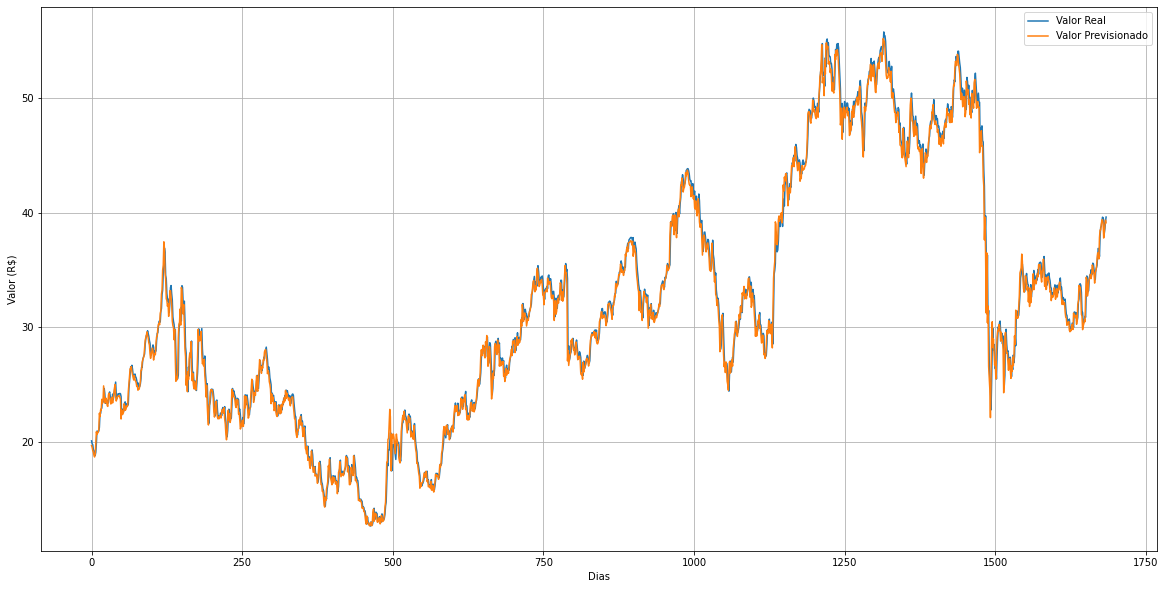

In [140]:
plt.figure(figsize=(20,10))
plt.plot(preds[:,0])
plt.plot(y)
plt.xlabel('Dias')
plt.ylabel('Valor (R$)')
plt.legend(["Valor Real", "Valor Previsionado"], loc="upper right")
plt.grid()